# Week 13 Problem 4

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

## Author: John Nguyen
### Primary Reviewer: Kelechi Ikegwu

# Due Date: 6 PM, April 23, 2018

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from nose.tools import (
    assert_equal,
    assert_is_instance,
    assert_almost_equal,
    assert_true,
    assert_is_not
)
from numpy.testing import assert_array_equal

import warnings
warnings.filterwarnings('ignore')

One area where probabilistic programming is extremely useful for is finance. For this assignment, we will build a quantitative financial model using what you've learned about probabilistic programming.

We will use the returns of the S&P 500 index. The data consists of changes in the S&P 500 from 11/01/2017 to 03/31/2018.

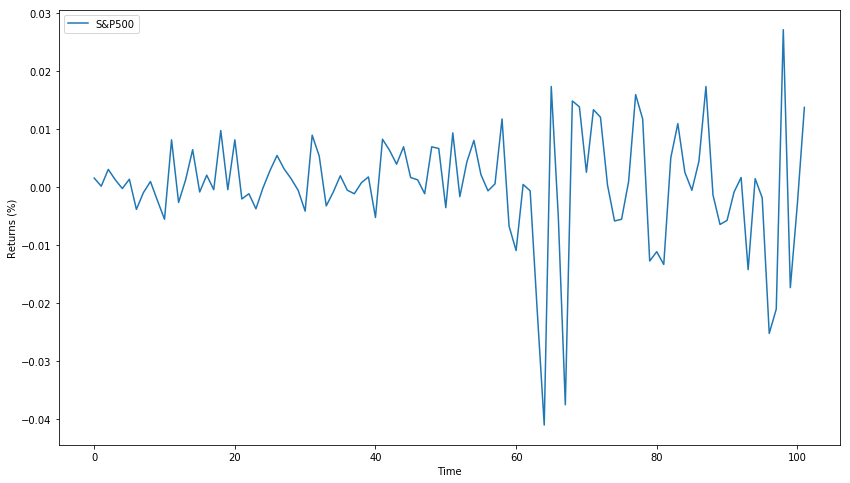

In [2]:
# Load in the dataset
returns = np.genfromtxt("/home/data_scientist/data/misc/sp500_nov17_mar18.csv", delimiter=',')
returns = returns[~np.isnan(returns)]

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns, label='S&P500')
ax.set(xlabel='Time', ylabel='Returns (%)')
ax.legend();

__Volatility__ is a measure of the dispersion of returns of a security or the market. ___Think of volatility as  standard deviation___, a measure which you should already be familiar with. It is one measure of "risk". From the figure, we see that returns are highly variable and so volatility is impossible to measure. For example, during a financial crash, we would expect a high volatility that gradually decreases over time. While we can't measure volatility, we can model it using a __stochastic volatility model__.

A simple stochastic volatility model assumes that returns are normally distributed which means the volatility would be captured as the standard deviation of the normal distribution. Another common assumption is that the standard deviation of the returns follow a [random walk process](https://en.wikipedia.org/wiki/Random_walk) which allows for the gradual for the slow, gradual changes over time. In other words, we will use a [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) as the basis to model volatility. Let us   use probabilisic programming to implement this model.


## Question 1

Build the following stochastic volatility model using the S&P 500 data:
<br><br>
<center>
$\nu \sim Exponential(\lambda=0.1)$ (Degrees of Freedom)
<br>
$\sigma \sim Exponential(\lambda=20)$ (Standard Deviation)
<br>
$s_i \sim Gaussian(s_{i-1}, \sigma^{-2})$ (Gaussian Random Walk)
<br>
$t \sim T(\nu, 0, e^{-2s_i})$ (Student's t-distribution)
</center>

You will need to specify the following for the stochastic model variables:

* dof = pm.Exponential():
    * Name the variable 'dof'
    * $\lambda = 0.1$
    * See the documentation for [Exponential distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) for more details.
* sigma = pm.Exponential():
    * Name the variable 'sigma'
    * $\lambda = 20$
* s = GaussianRandomWalk: 
    * Name the variable 's'
    * $ sd = \frac{1}{\sigma^2}$ (Hint: Use _sigma**-2_)
    * $shape=len(data)$
    * See the documentation for [Gaussian Random Walk](https://docs.pymc.io/api/distributions/timeseries.html#pymc3.distributions.timeseries.GaussianRandomWalk) for more details. 
* t = pm.StudentT(): 
    * Name the variable 't'
    * $nu = \nu$
    * $lam = e^{\left(-2*s_i\right)}$ (Hint: Use _pm.math.exp(-2*s)_)
    * $observed=data$
    * See the documentation for [Student's t-distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.StudentT) for more details.
    
Your function should output the model.

__Note__: You must name the stochastic model variables as shown in order to pass this assertions.

In [18]:
def stochastic_volatility_model(data):
    '''
    Build a Stochastic Volatility Model for the S&P 500 returns
    
    Paramters
    ---------
    data: an numpy.ndarray of the returns data
    
    Returns
    -------
    model: A pymc3.model.Model instance
    '''
    
    # YOUR CODE HERE
    with pm.Model() as model:
        dof =  pm.Exponential('dof',lam = 0.1)
        sigma = pm.Exponential('sigma',lam = 20)
        s = GaussianRandomWalk('s',sd = sigma**-2, shape = len(data))
        t = pm.StudentT('t', nu = dof, lam =  pm.math.exp(-2*s), observed = data)
    
    return model

In [19]:
# Build the model
model = stochastic_volatility_model(returns)

In [20]:
assert_equal(type(model), pm.model.Model)
assert_equal(type(model.dof), pm.model.TransformedRV)
assert_equal(type(model.sigma), pm.model.TransformedRV)
assert_equal(type(model.s), pm.model.FreeRV)
assert_equal(type(model.t), pm.model.ObservedRV)
assert_true('dof' in dir(model))
assert_true('sigma' in dir(model))
assert_true('s' in dir(model))

## Question 2

With the model you've built in Question 2, sample model parameters for this model to generate the traces using [sample()](https://docs.pymc.io/api/inference.html#module-pymc3.sampling).

Your function will take the pymc3 model along with the number of samples to draw and tune. Set the <i>random_seed</i> to be 10 for reproduceability.

__Hint__: You will need to use the _with_ statement. E.g.,

```
with model:
    trace = # DO SAMPLING HERE
```

In [23]:
def generate_samples(model, draw_value, tune_value):
    '''
    Sample the model parameters for this model to generate our traces
    
    Paramters
    ---------
    model: A pymc3.model.Model instance
    draw_value: An Int specifying the number of samples to draw
    tune_value: An Int specifying the number of iterations to tune
    
    Returns
    -------
    trace: A pymc3.MultiTrace instance
    ''' 
    
    # YOUR CODE HERE
    
    with model:
         trace = pm.sample(draw_value, tune=tune_value)
    
    return trace

In [24]:
# This might take a minute to run
trace = generate_samples(model, 1000, 100)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Average Loss = -294.76:  18%|█▊        | 36330/200000 [00:09<00:42, 3871.18it/s]
Convergence archived at 36700
Interrupted at 36,700 [18%]: Average Loss = -86.559
100%|██████████| 1100/1100 [00:09<00:00, 111.04it/s]


In [25]:
assert_equal(type(trace), pm.backends.base.MultiTrace)
assert_true('dof' in trace.varnames)
assert_true('sigma' in trace.varnames)
assert_true('s' in trace.varnames)
for v in trace.varnames:
    assert_equal(len(trace[v]), 1000)

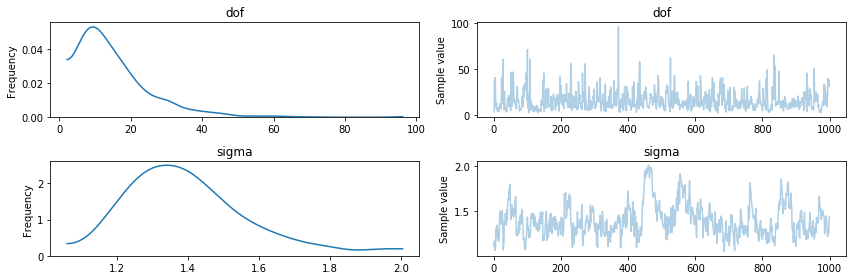

In [26]:
# View the trace plots
pm.traceplot(trace, [model.dof, model.sigma]);

Lets see how well our model was able to track volatility.

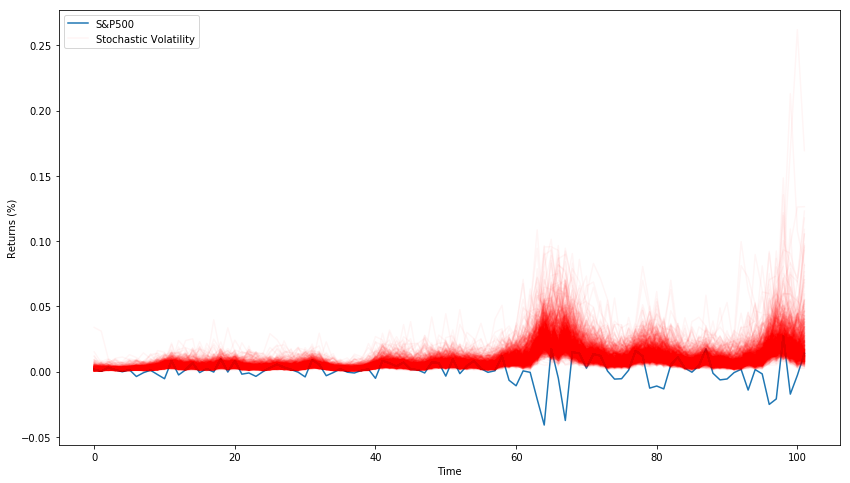

In [27]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns)
ax.plot(np.exp(trace[model.s].T), 'r', alpha=.04);
ax.set(xlabel='Time', ylabel='Returns (%)')
ax.legend(['S&P500', 'Stochastic Volatility']);